# 机器翻译与数据集
:label:`sec_machine_translation`

语言模型是自然语言处理的关键，
而*机器翻译*是语言模型最成功的基准测试。
因为机器翻译正是将输入序列转换成输出序列的
*序列转换模型*（sequence transduction）的核心问题。
序列转换模型在各类现代人工智能应用中发挥着至关重要的作用，
因此我们将其做为本章剩余部分和 :numref:`chap_attention`的重点。
为此，本节将介绍机器翻译问题及其后文需要使用的数据集。

*机器翻译*（machine translation）指的是
将序列从一种语言自动翻译成另一种语言。
事实上，这个研究领域可以追溯到数字计算机发明后不久的20世纪40年代，
特别是在第二次世界大战中使用计算机破解语言编码。
几十年来，在使用神经网络进行端到端学习的兴起之前，
统计学方法在这一领域一直占据主导地位
 :cite:`Brown.Cocke.Della-Pietra.ea.1988,Brown.Cocke.Della-Pietra.ea.1990`。
因为*统计机器翻译*（statistical machine translation）涉及了
翻译模型和语言模型等组成部分的统计分析，
因此基于神经网络的方法通常被称为
*神经机器翻译*（neural machine translation），
用于将两种翻译模型区分开来。

本书的关注点是神经网络机器翻译方法，强调的是端到端的学习。
与 :numref:`sec_language_model`中的语料库
是单一语言的语言模型问题存在不同，
机器翻译的数据集是由源语言和目标语言的文本序列对组成的。
因此，我们需要一种完全不同的方法来预处理机器翻译数据集，
而不是复用语言模型的预处理程序。
下面，我们看一下如何将预处理后的数据加载到小批量中用于训练。


In [1]:
import os
import torch
# from d2l import torch as d2l

## [**下载和预处理数据集**]

首先，下载一个由[Tatoeba项目的双语句子对](http://www.manythings.org/anki/)
组成的“英－法”数据集，数据集中的每一行都是制表符分隔的文本序列对，
序列对由英文文本序列和翻译后的法语文本序列组成。
请注意，每个文本序列可以是一个句子，
也可以是包含多个句子的一个段落。
在这个将英语翻译成法语的机器翻译问题中，
英语是*源语言*（source language），
法语是*目标语言*（target language）。


In [3]:
import os
import torch
import requests
import zipfile
import tarfile
import hashlib
from io import BytesIO

#@save
DATA_HUB = {}
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

DATA_HUB['fra-eng'] = (DATA_URL + 'fra-eng.zip',
                       '94646ad1522d915e7b0f9296181140edcf86a4f5')

def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

#@save
def read_data_nmt():
    """载入"英语-法语"数据集"""
    data_dir = download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r',
             encoding='utf-8') as f:
        return f.read()

# 测试代码
raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [5]:
# #@save
# d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
#                            '94646ad1522d915e7b0f9296181140edcf86a4f5')

# #@save
# def read_data_nmt():
#     """载入“英语－法语”数据集"""
#     data_dir = d2l.download_extract('fra-eng')
#     with open(os.path.join(data_dir, 'fra.txt'), 'r',
#              encoding='utf-8') as f:
#         return f.read()

raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



下载数据集后，原始文本数据需要经过[**几个预处理步骤**]。
例如，我们用空格代替*不间断空格*（non-breaking space），
使用小写字母替换大写字母，并在单词和标点符号之间插入空格。


In [6]:
#@save
def preprocess_nmt(text):
    """预处理“英语－法语”数据集"""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # 使用空格替换不间断空格
    # 使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 在单词和标点符号之间插入空格
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


## [**词元化**]

与 :numref:`sec_language_model`中的字符级词元化不同，
在机器翻译中，我们更喜欢单词级词元化
（最先进的模型可能使用更高级的词元化技术）。
下面的`tokenize_nmt`函数对前`num_examples`个文本序列对进行词元，
其中每个词元要么是一个词，要么是一个标点符号。
此函数返回两个词元列表：`source`和`target`：
`source[i]`是源语言（这里是英语）第$i$个文本序列的词元列表，
`target[i]`是目标语言（这里是法语）第$i$个文本序列的词元列表。


In [7]:
#@save
def tokenize_nmt(text, num_examples=None):
    """词元化“英语－法语”数据数据集"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

让我们[**绘制每个文本序列所包含的词元数量的直方图**]。
在这个简单的“英－法”数据集中，大多数文本序列的词元数量少于$20$个。


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """绘制列表长度对的直方图"""
    # 设置图形大小
    plt.figure(figsize=(3.5, 2.5))
    
    # 计算每个列表的长度
    x_lengths = [len(l) for l in xlist]
    y_lengths = [len(l) for l in ylist]
    
    # 绘制直方图
    _, bins, patches = plt.hist([x_lengths, y_lengths], label=legend)
    
    # 为第二个数据集（target）的条形添加斜线填充
    for patch in patches[1]:
        patch.set_hatch('/')
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(legend)
    plt.show()

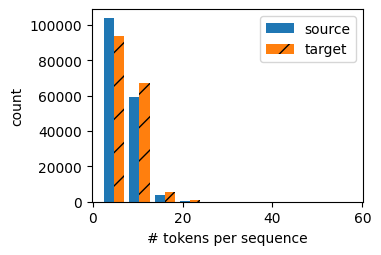

In [9]:
#@save
# def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
#     """绘制列表长度对的直方图"""
#     d2l.set_figsize()
#     _, _, patches = d2l.plt.hist(
#         [[len(l) for l in xlist], [len(l) for l in ylist]])
#     d2l.plt.xlabel(xlabel)
#     d2l.plt.ylabel(ylabel)
#     for patch in patches[1].patches:
#         patch.set_hatch('/')
#     d2l.plt.legend(legend)


show_list_len_pair_hist(['source', 'target'], '# tokens per sequence',
                        'count', source, target);

## [**词表**]

由于机器翻译数据集由语言对组成，
因此我们可以分别为源语言和目标语言构建两个词表。
使用单词级词元化时，词表大小将明显大于使用字符级词元化时的词表大小。
为了缓解这一问题，这里我们将出现次数少于2次的低频率词元
视为相同的未知（“&lt;unk&gt;”）词元。
除此之外，我们还指定了额外的特定词元，
例如在小批量时用于将序列填充到相同长度的填充词元（“&lt;pad&gt;”），
以及序列的开始词元（“&lt;bos&gt;”）和结束词元（“&lt;eos&gt;”）。
这些特殊词元在自然语言处理任务中比较常用。


In [10]:
import collections

class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs
    
def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [11]:
src_vocab = Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

## 加载数据集
:label:`subsec_mt_data_loading`

回想一下，语言模型中的[**序列样本都有一个固定的长度**]，
无论这个样本是一个句子的一部分还是跨越了多个句子的一个片断。
这个固定长度是由 :numref:`sec_language_model`中的
`num_steps`（时间步数或词元数量）参数指定的。
在机器翻译中，每个样本都是由源和目标组成的文本序列对，
其中的每个文本序列可能具有不同的长度。

为了提高计算效率，我们仍然可以通过*截断*（truncation）和
*填充*（padding）方式实现一次只处理一个小批量的文本序列。
假设同一个小批量中的每个序列都应该具有相同的长度`num_steps`，
那么如果文本序列的词元数目少于`num_steps`时，
我们将继续在其末尾添加特定的“&lt;pad&gt;”词元，
直到其长度达到`num_steps`；
反之，我们将截断文本序列时，只取其前`num_steps` 个词元，
并且丢弃剩余的词元。这样，每个文本序列将具有相同的长度，
以便以相同形状的小批量进行加载。

如前所述，下面的`truncate_pad`函数将(**截断或填充文本序列**)。


In [12]:
#@save
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

现在我们定义一个函数，可以将文本序列
[**转换成小批量数据集用于训练**]。
我们将特定的“&lt;eos&gt;”词元添加到所有序列的末尾，
用于表示序列的结束。
当模型通过一个词元接一个词元地生成序列进行预测时，
生成的“&lt;eos&gt;”词元说明完成了序列输出工作。
此外，我们还记录了每个文本序列的长度，
统计长度时排除了填充词元，
在稍后将要介绍的一些模型会需要这个长度信息。


In [13]:
#@save
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

## [**训练模型**]

最后，我们定义`load_data_nmt`函数来返回数据迭代器，
以及源语言和目标语言的两种词表。


In [14]:
from torch.utils import data

def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [15]:
#@save
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词表"""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

下面我们[**读出“英语－法语”数据集中的第一个小批量数据**]。


In [17]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('X的有效长度:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('Y的有效长度:', Y_valid_len)
    break

X: tensor([[ 0, 12,  4,  3,  1,  1,  1,  1],
        [ 6, 22,  4,  3,  1,  1,  1,  1]], dtype=torch.int32)
X的有效长度: tensor([4, 4])
Y: tensor([[ 0,  4,  3,  1,  1,  1,  1,  1],
        [21, 25,  4,  3,  1,  1,  1,  1]], dtype=torch.int32)
Y的有效长度: tensor([3, 4])


## 小结

* 机器翻译指的是将文本序列从一种语言自动翻译成另一种语言。
* 使用单词级词元化时的词表大小，将明显大于使用字符级词元化时的词表大小。为了缓解这一问题，我们可以将低频词元视为相同的未知词元。
* 通过截断和填充文本序列，可以保证所有的文本序列都具有相同的长度，以便以小批量的方式加载。

## 练习

1. 在`load_data_nmt`函数中尝试不同的`num_examples`参数值。这对源语言和目标语言的词表大小有何影响？
1. 某些语言（例如中文和日语）的文本没有单词边界指示符（例如空格）。对于这种情况，单词级词元化仍然是个好主意吗？为什么？


[Discussions](https://discuss.d2l.ai/t/2776)
